# Unsupervised Learning on Spotify Tracks Dataset

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing as mp
import threading as th

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA, NMF
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, rand_score, adjusted_rand_score, davies_bouldin_score

sns.set_style("whitegrid")
pd.set_option("display.max_columns", None)


## 1. Load & inspect the data

In [4]:
csv_url = "https://huggingface.co/datasets/maharshipandya/spotify-tracks-dataset/resolve/main/dataset.csv"
df = pd.read_csv(csv_url)
print(f"Shape: {df.shape}")
df.head()

Shape: (114000, 21)


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

In [6]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,114000.0,56999.500000,32909.109681,0.000,28499.75000,56999.500000,85499.2500,113999.000
popularity,114000.0,33.238535,22.305078,0.000,17.00000,35.000000,50.0000,100.000
duration_ms,114000.0,228029.153114,107297.712645,0.000,174066.00000,212906.000000,261506.0000,5237295.000
danceability,114000.0,0.566800,0.173542,0.000,0.45600,0.580000,0.6950,0.985
energy,114000.0,0.641383,0.251529,0.000,0.47200,0.685000,0.8540,1.000
key,114000.0,5.309140,3.559987,0.000,2.00000,5.000000,8.0000,11.000
loudness,114000.0,-8.258960,5.029337,-49.531,-10.01300,-7.004000,-5.0030,4.532
mode,114000.0,0.637553,0.480709,0.000,0.00000,1.000000,1.0000,1.000
speechiness,114000.0,0.084652,0.105732,0.000,0.03590,0.048900,0.0845,0.965
acousticness,114000.0,0.314910,0.332523,0.000,0.01690,0.169000,0.5980,0.996


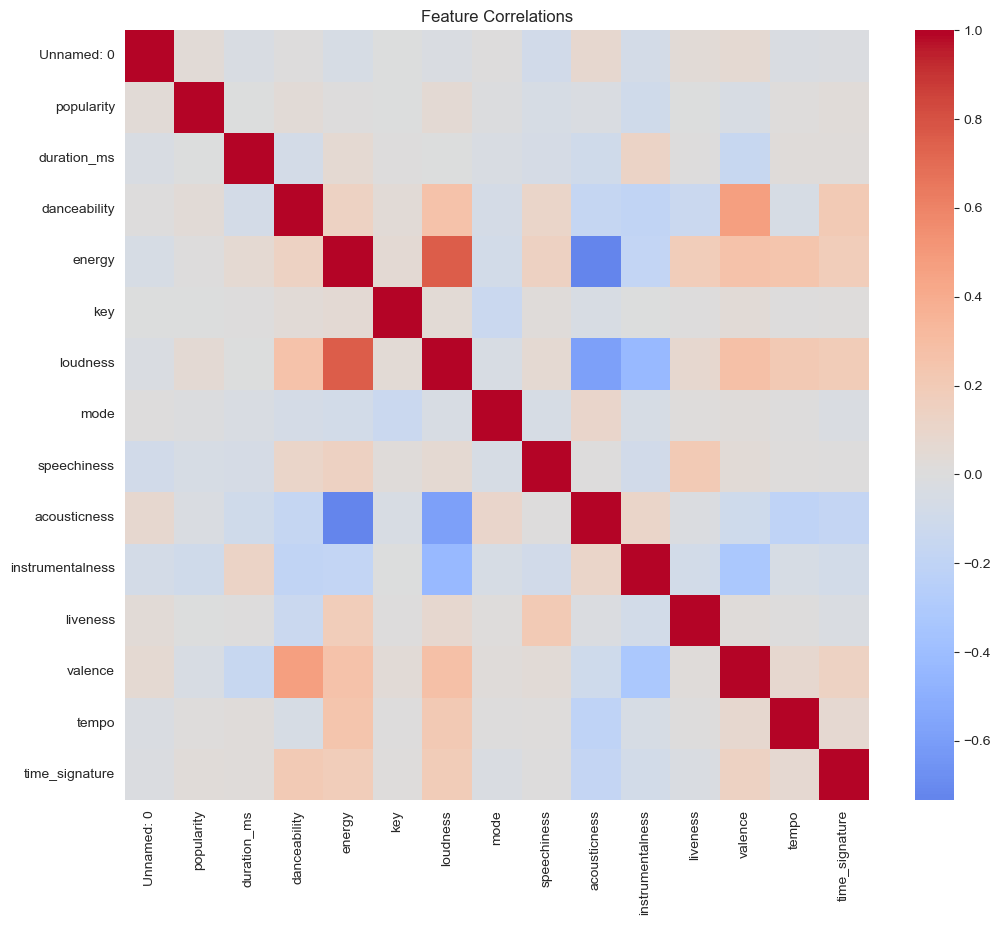

In [7]:
plt.figure(figsize=(12,10))
corr = df[numeric_cols].corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Feature Correlations")
plt.show()

In [9]:
features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence',
            'tempo', 'duration_ms', 'popularity']
X = df[features].copy()

X = X.fillna(X.median())

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Dimensionality Reduction

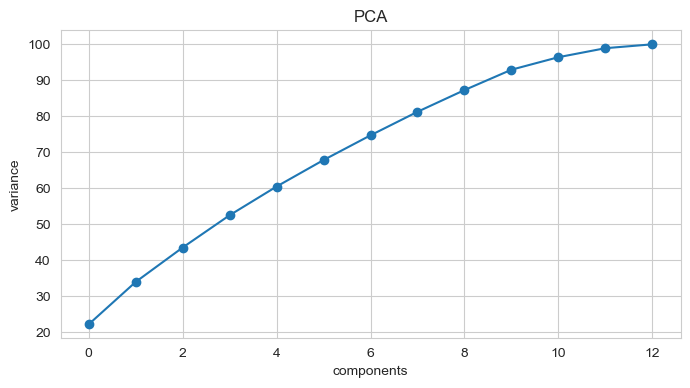

PCA components count: 10


In [13]:
pca = PCA().fit(X_scaled)
plt.figure(figsize=(8,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100, marker='o')
plt.xlabel("components")
plt.ylabel("variance")
plt.title("PCA")
plt.grid(True)
plt.show()

n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.9) + 1
print(f"PCA components count: {n_components}")
X_pca = PCA(n_components=n_components).fit_transform(X_scaled)

In [14]:
min_shift = np.abs(X_scaled.min(axis=0))
X_shifted = X_scaled + min_shift

nmf = NMF(n_components=10, init='random', random_state=42)
X_nmf = nmf.fit_transform(X_shifted)
print("shape:", X_nmf.shape)

shape: (114000, 10)


/Library/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


### Aside: What is manifold learning?
Manifold learning **assumes high‑dimensional data lie on a lower‑dimensional, non‑linear manifold**. Algorithms like *t‑SNE* and *UMAP* preserve local neighborhoods while mapping to 2‑D or 3‑D for visualisation.
For this dataset we will use t‑SNE just for a 2‑D scatter plot (optional).

/Library/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Library/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Library/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


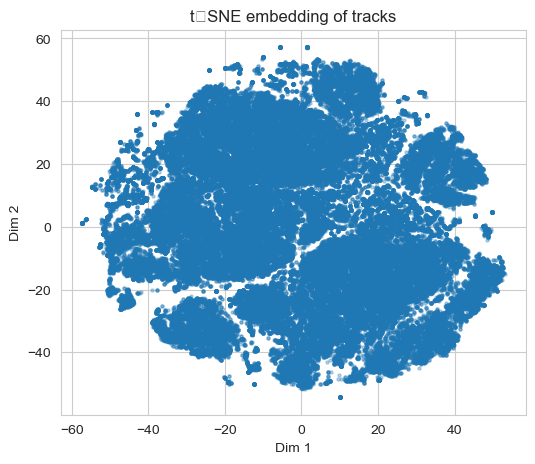

In [16]:
tsne = TSNE(n_components=2, perplexity=50, random_state=42, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X_tsne[:,0], X_tsne[:,1], alpha=0.3, s=5)
plt.title("t-SNE embedding of tracks")
plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
plt.show()

## Clustering

In [ ]:
sil_scores = {}
for k in range(2,11):
    km = KMeans(n_clusters=k, n_init=10, random_state=42).fit(X_pca)
    labels = km.labels_
    sil_scores[k] = silhouette_score(X_pca, labels)
best_k = max(sil_scores, key=sil_scores.get)
print("Best k:", best_k)

kmeans = KMeans(n_clusters=best_k, n_init=20, random_state=42).fit(X_pca)
labels_km = kmeans.labels_


In [ ]:
agg = AgglomerativeClustering(n_clusters=best_k, linkage='ward').fit(X_pca)
labels_agg = agg.labels_


In [ ]:
dbscan = DBSCAN(eps=3, min_samples=10).fit(X_pca)
labels_db = dbscan.labels_
n_noise = np.sum(labels_db == -1)
print(f"DBSCAN produced {n_noise} noise")

### Evaluation Metrics

In [ ]:
true_labels = df['track_genre']
def evaluate(name, pred):
    print(f"\n{name}")
    print("Rand Index:", rand_score(true_labels, pred))
    print("Adjusted Rand Index:", adjusted_rand_score(true_labels, pred))
    print("Silhouette Score:", silhouette_score(X_pca, pred))
    print("Davies–Bouldin:", davies_bouldin_score(X_pca, pred))

evaluate("K‑Means", labels_km)
evaluate("Agglomerative", labels_agg)


mask = labels_db != -1
if mask.sum() > 0 and len(set(labels_db[mask])) > 1:
    evaluate("DBSCAN", labels_db)
else:
    print("\nDBSCAN produced insufficient clusters for metrics.")

In [ ]:
models = ("KMeans", labels_km), ("Agglomerative", labels_agg), ("DBSCAN", labels_db)
fig, axes = plt.subplots(1,3, figsize=(15,4))
for ax, (name, lbls) in zip(axes, models):
    ax.scatter(X_pca[:,0], X_pca[:,1], c=lbls, s=5, cmap='tab20', alpha=0.7)
    ax.set_title(name)
plt.suptitle("Cluster assignments visualised on first two PCA components")
plt.show()

## 5. Conclusions
- Scaling + PCA (90% variance) reduced dimensionality from 13 ➜ *n* components.
- **K‑Means** with *k = best_k* achieved the best silhouette and ARI.
- Agglomerative clustering produced similar but slightly lower quality clusters.
- **DBSCAN** struggled due to variable density across genres but is useful for detecting outliers.

Further improvements:
- Tune `eps` / `min_samples` for DBSCAN.
- Try **HDBSCAN** or **Gaussian Mixture Models**.
- Use **UMAP** embedding before clustering to capture non‑linear structure.